### Spectogram

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten, BatchNormalization
from keras.models import Sequential
import librosa.display


In [2]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [38]:
POS = os.path.join('Snoring Dataset', '1')
NEG = os.path.join('Data', 'Non_Snoring')
#POS2 = os.path.join('Data', 'Snoring')
#NEG2 = os.path.join('Data', 'Silence')
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')
#pos2 = tf.data.Dataset.list_files(POS2+'\*.wav')
#neg2 = tf.data.Dataset.list_files(NEG2+'\*.wav')
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
#positives2 = tf.data.Dataset.zip((pos2, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos2)))))
#negatives2 = tf.data.Dataset.zip((neg2, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg2)))))
data = positives.concatenate(negatives)#.concatenate(positives2).concatenate(negatives2)

In [39]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:25000]
    zero_padding = tf.zeros([25000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=512, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

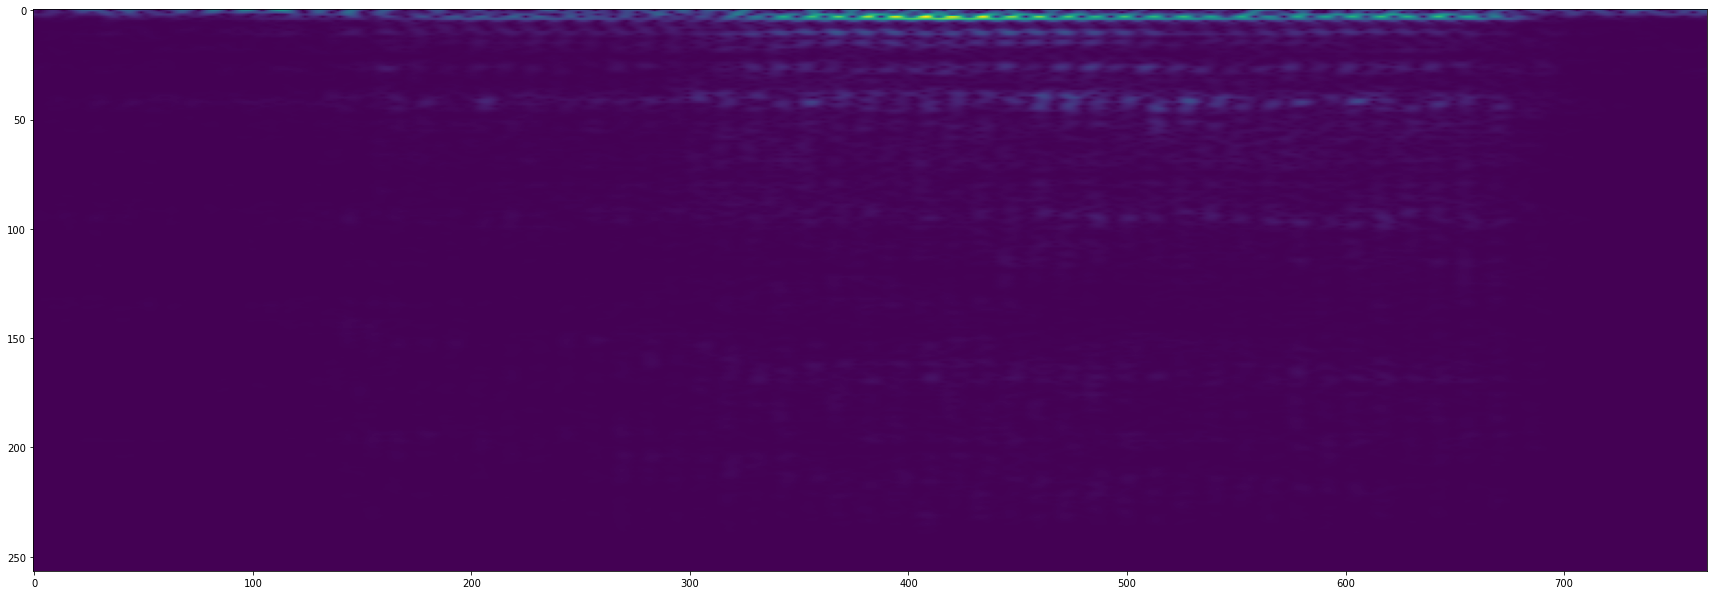

In [40]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [41]:
spectrogram

<tf.Tensor: shape=(766, 257, 1), dtype=float32, numpy=
array([[[1.3691043e+00],
        [1.0435009e+00],
        [1.5173081e+00],
        ...,
        [2.5158473e-05],
        [7.9313459e-06],
        [1.1086464e-05]],

       [[8.5946238e-01],
        [5.0323361e-01],
        [1.3660320e+00],
        ...,
        [2.9763150e-05],
        [1.4186354e-05],
        [1.0132790e-05]],

       [[3.6714458e-01],
        [2.1737511e-01],
        [1.2792107e+00],
        ...,
        [3.3658980e-05],
        [1.6749871e-05],
        [1.1429191e-05]],

       ...,

       [[4.1719356e+00],
        [3.4591522e+00],
        [2.5055275e+00],
        ...,
        [9.5748510e-06],
        [9.3751869e-06],
        [2.3841858e-06]],

       [[4.2462301e+00],
        [3.7085073e+00],
        [2.4100246e+00],
        ...,
        [9.9709405e-06],
        [1.1222870e-05],
        [2.8610229e-06]],

       [[4.1370850e+00],
        [3.5884247e+00],
        [2.2812874e+00],
        ...,
        [1.1014448e

In [126]:
# spectrogram = (spectrogram - min(spectrogram)/(max(spectrogram) - min(spectrogram)))

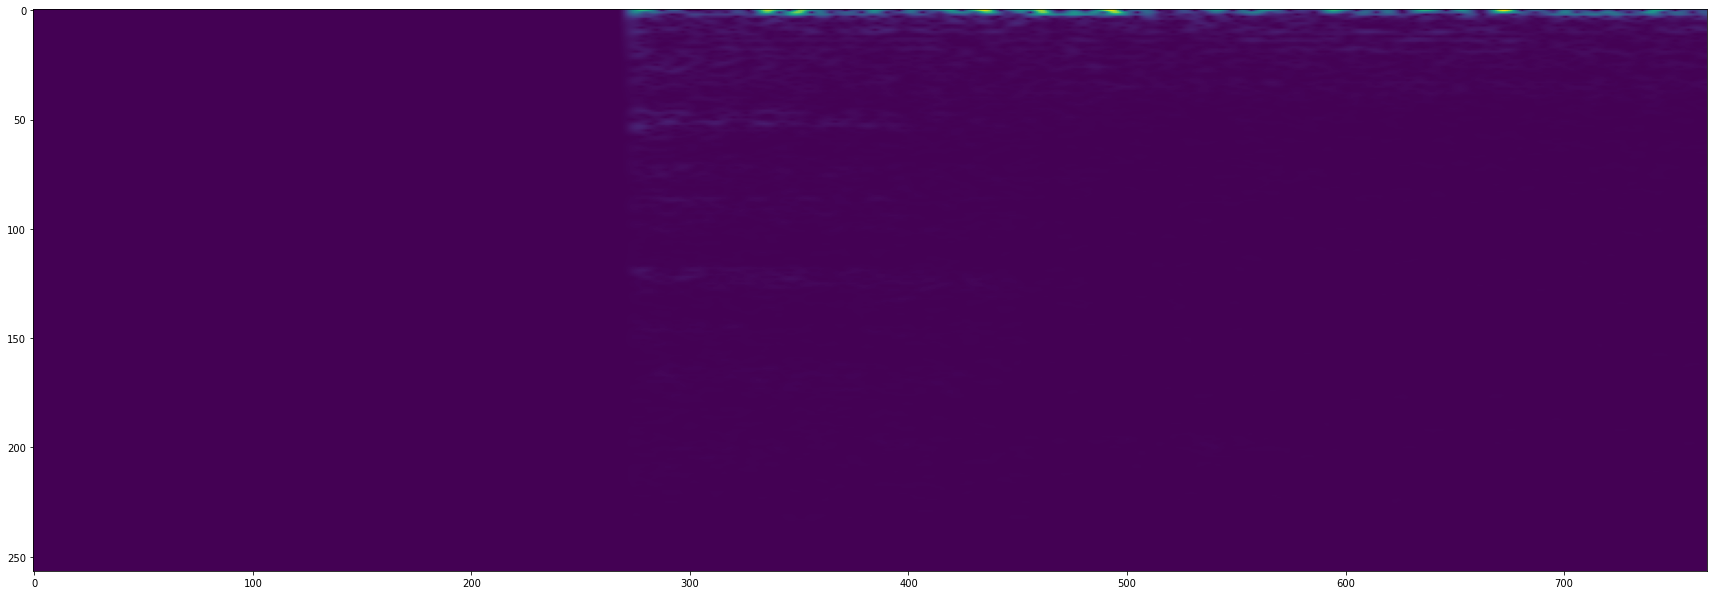

In [42]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [43]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=5000)
data = data.batch(16)
datea = data.prefetch(8)

In [45]:
len(data)*.7

262.5

In [46]:
train = data.take(263)
test = data.skip(263).take(112)

In [47]:
samples, labels = train.as_numpy_iterator().next()
# samples.shape

In [48]:
samples.shape

(16, 766, 257, 1)

In [153]:
tf.keras.backend.clear_session()

In [157]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)
model = Sequential()

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(766, 257,1)))
model.add(BatchNormalization())

model.add(Conv2D(16, (2,2), activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2), ))

model.add(Conv2D(16, (2,2), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(16, (2,2), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), ))

model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='softmax'))

In [158]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Accuracy(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 764, 255, 16)      160       
                                                                 
 batch_normalization_4 (Batc  (None, 764, 255, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 763, 254, 16)      1040      
                                                                 
 batch_normalization_5 (Batc  (None, 763, 254, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 381, 127, 16)     0         
 2D)                                                             
                                                      

In [159]:
hist = model.fit(train, epochs=100, validation_data=test)

Epoch 1/100
  8/263 [..............................] - ETA: 8:26 - loss: 10.4205 - accuracy: 0.5938 - precision_1: 0.5938

KeyboardInterrupt: 

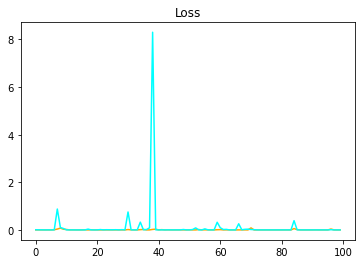

In [104]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'orange')
plt.plot(hist.history['val_loss'], 'cyan')
plt.show()

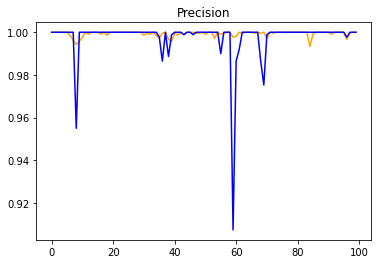

In [105]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'orange')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

In [160]:
# plt.title('Recall')
# plt.plot(hist.history['recall'], 'orange')
# plt.plot(hist.history['val_recall'], 'b')
# plt.show()

In [107]:
X_test = test.map(lambda X_test, y_test: X_test)
y_test = test.map(lambda X_test, y_test: y_test)

In [108]:
model.evaluate(test)

112/112 [==============================] - 30s 225ms/step - loss: 6.0963e-05 - accuracy: 0.4777 - precision: 1.0000


[6.096334618632682e-05, 0.4776536226272583, 1.0]

In [119]:
yhat = model.predict(X_test[:16])
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
yhat

In [57]:
y_test[:16].astype(int)

array([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0])

In [ ]:
model.evaluate(X_test, y_test)

In [110]:
def load_mp3(filename):
    res = tfio.audio.AudioIOTensor(filename)
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis = 1)
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype = tf.int64)
    wav = tfio.audio.resample(tensor, rate_in = sample_rate, rate_out =16000)
    return wav

In [111]:
mp3 = os.path.join('SnoringMP3','A2.mp3')
wav = load_mp3(mp3)
audio_slice = tf.keras.utils.timeseries_dataset_from_array(wav,wav, sequence_length = 27000, sequence_stride = 27000, batch_size = 1)

In [112]:
samples, index = audio_slice.as_numpy_iterator().next()
samples.shape

(1, 27000)

In [113]:
def prep_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([27000] - tf.shape(sample), dtype = tf.float32)
    wav = tf.concat([zero_padding, sample], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis = 2)
    return spectrogram
    

In [114]:
audio = tf.keras.utils.timeseries_dataset_from_array(wav,wav, sequence_length = 27000, sequence_stride = 27000, batch_size = 1)
audio = audio.map(prep_mp3)
audio = audio.batch(64)

In [120]:
yhat = model.predict(audio)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [116]:
def predict(filepath):
    wav = load_mp3(filepath)
    audio = tf.keras.utils.timeseries_dataset_from_array(wav,wav, sequence_length = 27000, sequence_stride = 27000, batch_size = 1)
    audio = audio.map(prep_mp3)
    audio = audio.batch(64)
    yhat = model.predict(audio)
    yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
    return yhat , spectrogram
    

In [121]:
mp3 = os.path.join('SnoringMP3','Sea.mp3')
predict(mp3)

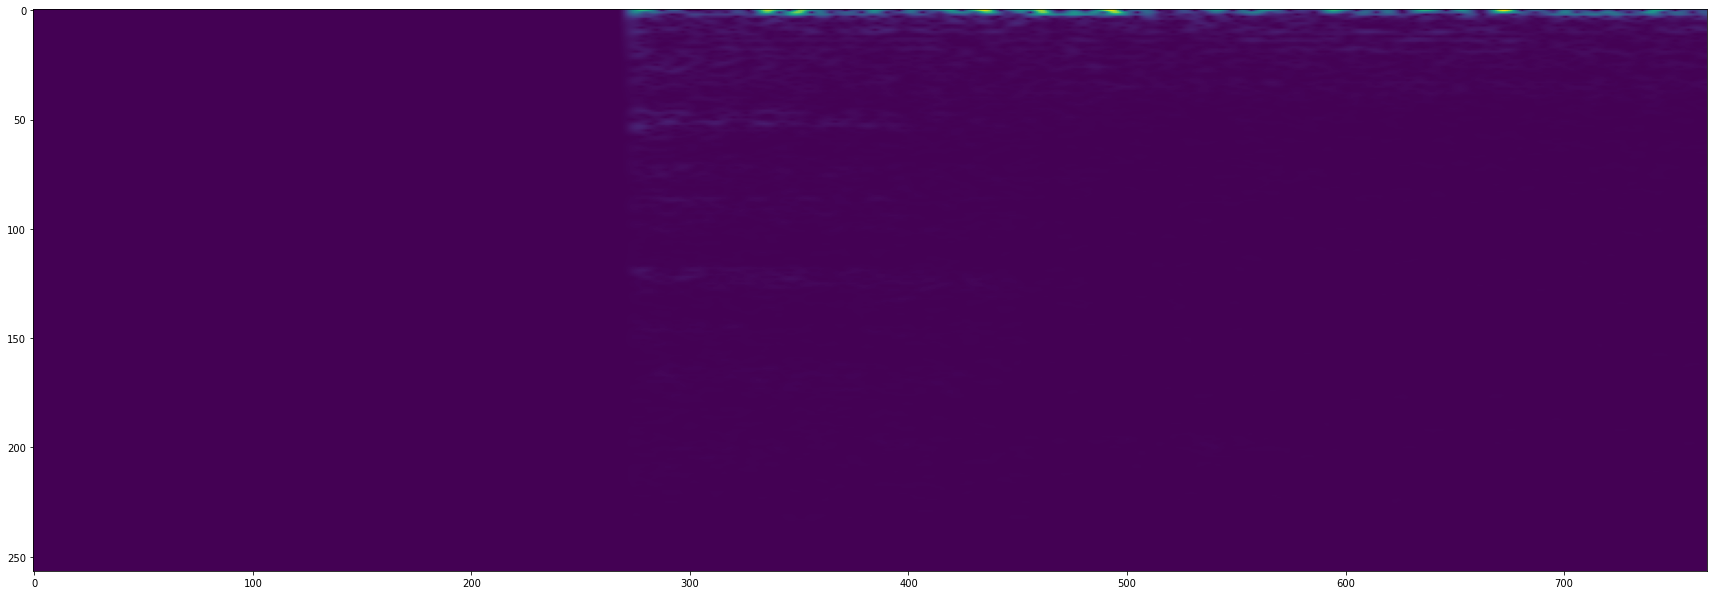

In [118]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [147]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import librosa.display
import librosa
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from tqdm import tqdm

In [148]:
SAMPLING_RATE = 44100
MFCC_NUM = 20
MFCC_MAX_LEN = 2000

In [161]:
import os, shutil
import librosa
import numpy as np
import skimage.io 
import json
import matplotlib.pyplot as plt
import joblib

savepath = '//'
trainpath = '//'

hop_length = 512
n_mels = 128
time_steps = 250
start_sample = 0
length_samples = time_steps*hop_length

def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def spectrogram_image(y, sr, out, hop_length, n_mels):
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,n_fft=2048, hop_length=hop_length)
    #mels = numpy.log(mels + 1e-9) # add small number to avoid log(0)
    mels = librosa.power_to_db(mels, ref=np.max)
    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy
    skimage.io.imsave(out, img)

def process_files(directory):
    for folder in os.listdir(directory):
        endpath = os.path.join(savepath, folder)
        os.mkdir(endpath)
        inpath = os.path.join(directory, folder)
        for soundclip in os.listdir(inpath):
            endpath_file = str(endpath + '/'+soundclip[:-4]+ '.png')
            sound_orig = os.path.join(inpath, soundclip)
            y, sr = librosa.load(sound_orig, sr=22050)
            window = y[start_sample:start_sample+length_samples]
            spectrogram_image(window, sr=sr, out=endpath_file, hop_length=hop_length, n_mels=n_mels)

In [193]:

for folder in os.listdir("Data/Non_Snoring"):
    inpath = os.path.join("Data/Non_Snoring")
    for soundclip in os.listdir(inpath):
        endpath_file = str("Data/Save" + '/'+soundclip[:-4]+ '.png')
        sound_orig = os.path.join(inpath, soundclip)
        y, sr = librosa.load(sound_orig, sr=22050)
        window = y[start_sample:start_sample+length_samples]
        spectrogram_image(window, sr=sr, out=endpath_file, hop_length=hop_length, n_mels=n_mels)
        # for file in os.listdir(os.path.join('Data','Non_Snoring')):

: 

'Snoring Dataset\\Save\\1_99.wav'